In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [2]:
path = r'C:\Users\Admin\Documents\Career Foundry\Achievement 6\Data'
df = pd.read_csv(os.path.join(path,'pip_dataset.csv'))

In [3]:
selected_df = df[[
    'year',
    'headcount_100',
    'country'
]].copy()

# Filter for only 'world' rows
world_df = selected_df[selected_df['country'] == 'World']

# Group by year 
grouped_df = world_df.groupby('year')['headcount_100'].mean().reset_index()
grouped_df.head()

,year,headcount_100
0,1990,518683683.5
1,1991,519268603.5
2,1992,505940630.0
3,1993,492536953.0
4,1994,458220975.5


## Explanation for data choice
The column 'country' is the name of the country to which the row relates. It can be: 1) Countries, whose names have been standardized to a common set of country names used across Our World in Data 2) Regional aggregates provided as standard within the PIP data according to World Bank region definitions. Because depending on the different countries, quite a lot of data is missing. After doing some exploring of the data I decided to filter my values for the 'World' value from 1990 to 2019 to avoid the issue of missing data.

In [4]:
grouped_df['year_date'] = pd.to_datetime(grouped_df['year'].astype(str), format='%Y') # Create a datetime column from "Date.""
grouped_df = grouped_df.set_index('year_date') # Set the datetime as the index of the dataframe.
grouped_df.drop(['year'], axis=1, inplace=True) # Drop the "Date" column.
grouped_df.head()

,headcount_100
year_date,
1990-01-01,518683683.5
1991-01-01,519268603.5
1992-01-01,505940630.0
1993-01-01,492536953.0
1994-01-01,458220975.5


In [5]:
# Checking for missing years
print("Years in the dataset:")
print(grouped_df.index.year.sort_values().unique())
grouped_df.head()

Years in the dataset:
Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019],
      dtype='int32', name='year_date')


,headcount_100
year_date,
1990-01-01,518683683.5
1991-01-01,519268603.5
1992-01-01,505940630.0
1993-01-01,492536953.0
1994-01-01,458220975.5


In [6]:
# 1. First create complete year range and interpolate missing years
complete_range = pd.date_range(start='1990-01-01', end='2019-01-01', freq='YS')
grouped_df = grouped_df.reindex(complete_range)
grouped_df = grouped_df.interpolate(method='linear')
grouped_df.head()

,headcount_100
1990-01-01,518683683.5
1991-01-01,519268603.5
1992-01-01,505940630.0
1993-01-01,492536953.0
1994-01-01,458220975.5


In [7]:
# 1. Identify Outliers (using IQR)
q1 = grouped_df['headcount_100'].quantile(0.25)
q3 = grouped_df['headcount_100'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Find outliers
outliers = (grouped_df['headcount_100'] < lower_bound) | (grouped_df['headcount_100'] > upper_bound)

# 2. Replace outliers with NaN
grouped_df.loc[outliers, 'headcount_100'] = np.nan

# 3. Interpolate to fill NaN values
grouped_df['headcount_100'] = grouped_df['headcount_100'].interpolate(method='linear')


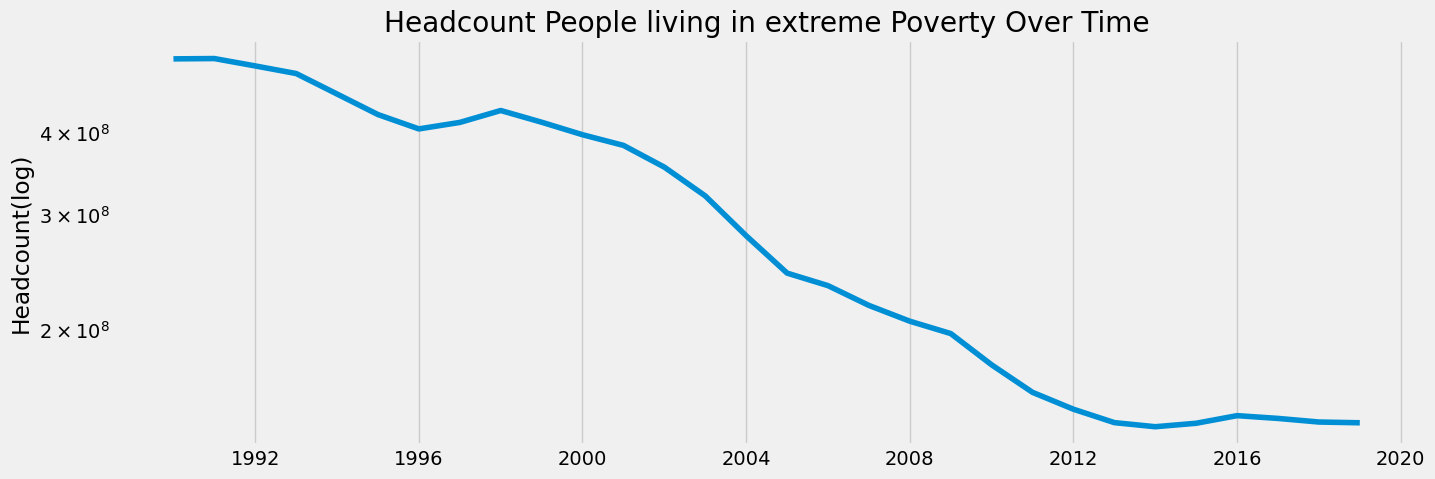

In [8]:
# Plot
plt.figure(figsize=(15,5), dpi=100)
plt.plot(grouped_df['headcount_100'])
plt.title('Headcount People living in extreme Poverty Over Time')
# Set y-axis to logarithmic scale
plt.yscale('log')
plt.ylabel('Headcount(log)')
plt.grid(True)

In [9]:
# Decompose the time series using an multiplicative model, since the change in not linear.
decomposition = sm.tsa.seasonal_decompose(grouped_df, model='multiplicative',period=12)

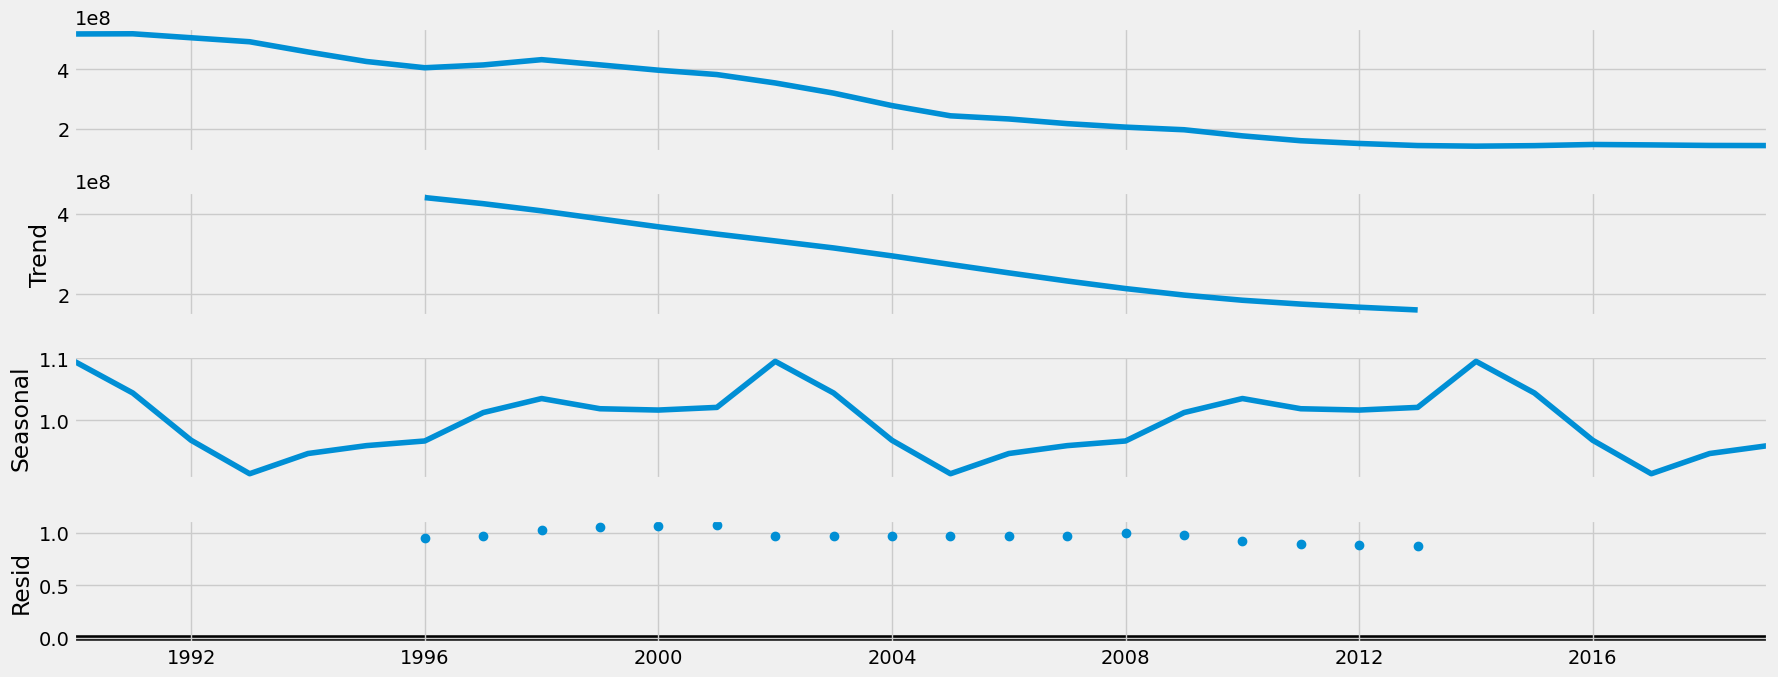

In [10]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7
# Plot the separate components
decomposition.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(grouped_df['headcount_100'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.413143
p-value                         0.010519
Number of Lags Used             8.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


# Interpretation
Our Test Statistic, -3.413143, is smaller than the 10% and 5% critical value, which means that we can reject the null hypothesis (which is: the data is not stationnary) with a certitude of 95%. Our p-value of 0.010519 is less than 0.05, which means that the result is significant. We can consider the series stationnary

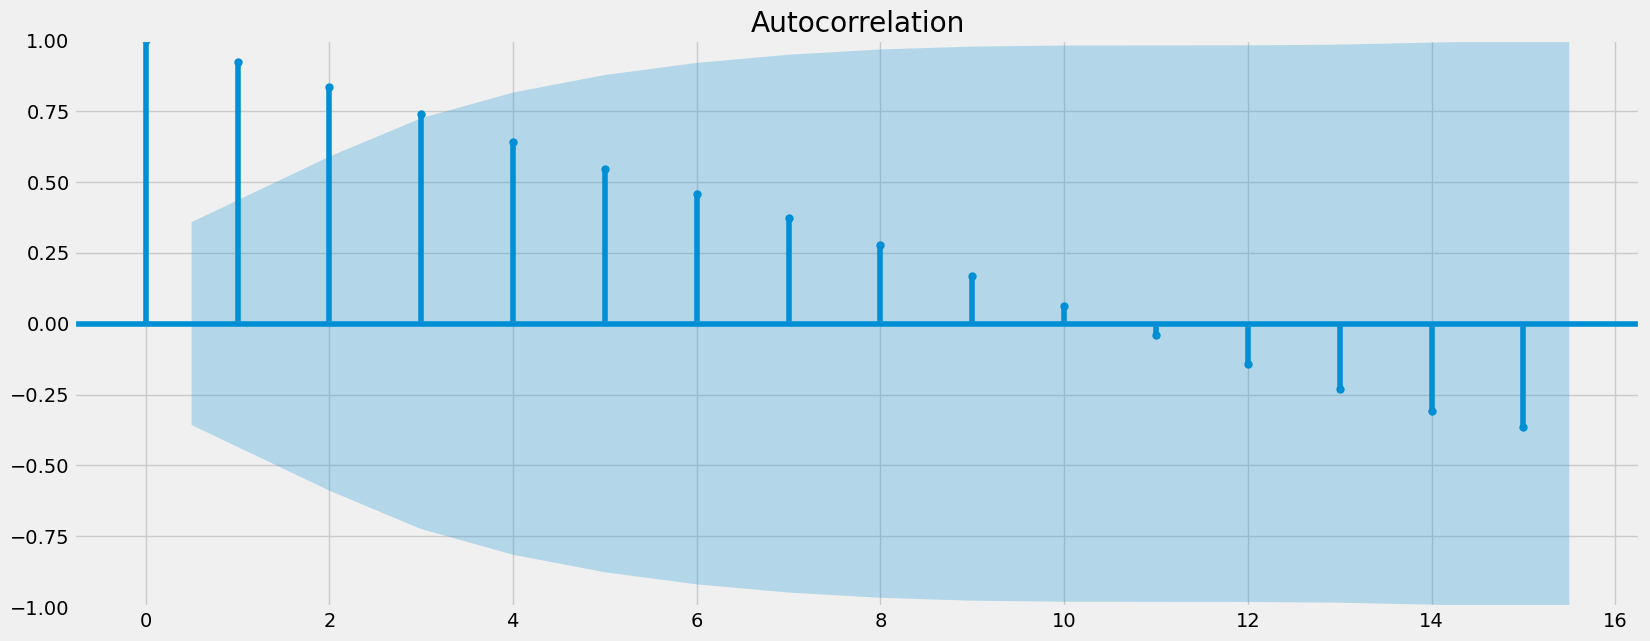

In [12]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(grouped_df)
plt.show()

# Interpretation
We have identified 3 lags that exceed the confidence interval, indicating that the data is not fully stationary. However, this number of lags is minimal, and therefore, no differencing is required.